In [1]:
import sys
sys.path.insert(1, 'F:/Dev/LMEmbeddingAnalysis/') # Change to what you need

In [2]:
import os
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import ScalarFormatter

from utils.yaml_utils import read_yaml_file
from utils.constants import HOME_DIR_WIN

In [3]:
analysis_type_descriptions = {
    'full':'Original Embedding Weights',
    'random_xn':'Random Embedding Weights',
    'crop_128':'Embeddings Cropped to 128 Dims',
    'crop_512':'Embeddings Cropped to 512 Dims',
    'pad_4096':'Embeddings Padded to 4096 Dims',
    'pad_5120':'Embeddings Padded to 5012 Dims',
    'pad_9216':'Embeddings Padded to 9216 Dims',
    'pad_14336':'Embeddings Padded to 14336 Dims',
    'pad_12288':'Embeddings Padded to 12288 Dims',
}

In [4]:
# Create a directory for plots if it doesn't exist
plots_dir = f"{HOME_DIR_WIN}/plots"
os.makedirs(plots_dir, exist_ok=True)

In [175]:
# model_names = [
#     'pythia-14m',
#     'pythia-31m',
#     'pythia-70m',
#     'pythia-160m',
#     'pythia-410m',
#     'pythia-1b',
#     'pythia-1.4b',
#     'pythia-2.8b',
#     'pythia-6.9B',
#     'pythia-12b',
# ]

# model_sizes = {
#     'pythia-14m':128,
#     'pythia-31m':256,
#     'pythia-70m':512,
#     'pythia-160m':768,
#     'pythia-410m':1024,
#     'pythia-1b':2048,
#     'pythia-1.4b':2048,
#     'pythia-2.8b':2560,
#     'pythia-6.9B':4096,
#     'pythia-12b':5120,
# }

model_names = [
    "opt-350m",
    "opt-125m",
    "opt-1.3b",
    "opt-2.7b",
    "opt-6.7b",
    "opt-13b",
    "opt-30b",
    "opt-66b",
    "opt-175b",
]

model_sizes = {
    "opt-350m":512,
    "opt-125m":768,
    "opt-1.3b":2048,
    "opt-2.7b":2560,
    "opt-6.7b":4096,
    "opt-13b":5120,
    "opt-30b":7168,
    "opt-66b":9216,
    "opt-175b":12288,
} 

# model_names = [
#     "Cerebras-GPT-111M",
#     "Cerebras-GPT-256M",
#     "Cerebras-GPT-590M",
#     "Cerebras-GPT-1.3B",
#     "Cerebras-GPT-2.7B",
#     "Cerebras-GPT-6.7B",
#     "Cerebras-GPT-13B",
# ]

# model_sizes = {
#     "Cerebras-GPT-111M":768,
#     "Cerebras-GPT-256M":1088,
#     "Cerebras-GPT-590M":1536,
#     "Cerebras-GPT-1.3B":2048,
#     "Cerebras-GPT-2.7B":2560,
#     "Cerebras-GPT-6.7B":4096,
#     "Cerebras-GPT-13B":5120,
# }
    
# model_names = [
#     "bloom-560m",
#     "bloom-1b1",
#     "bloom-1b7",
#     "bloom-3b",
#     "bloom-7b1",
#     "bloom",
# ]

# model_sizes = {
#     "bloom-560m":1024,
#     "bloom-1b1":1536,
#     "bloom-1b7":2048,
#     "bloom-3b":2560,
#     "bloom-7b1":4096,
#     "bloom":14336,
# }

# model_names = [
#     "t5-v1_1-small",
#     "t5-v1_1-base",
#     "t5-v1_1-large",
#     "t5-v1_1-xl",
#     "t5-v1_1-xxl",
# ]

# model_sizes = {
#     "t5-v1_1-small":512,
#     "t5-v1_1-base":768,
#     "t5-v1_1-large":1024,
#     "t5-v1_1-xl":2048,
#     "t5-v1_1-xxl":4096,
# }

analysis_types = [
    'full',
    'random_xn',
    # 'crop_768', # Deprecated
    # 'crop_512',
    'crop_128',
    # 'pad_4096',
    # 'pad_5120',
    # 'pad_9216',
    'pad_12288',
    # 'pad_14336',
]

# TITLE = "Pythia"
TITLE = "OPT"
# TITLE = "Cerebras"
# TITLE = "Bloom"
# TITLE = "T5-v1_1"

In [176]:
# Dictionary to store scores for each task, score type, and model
task_scores = {}

pooling_modes = ["mean"] #, "max", "cls"] #Note, I had issues with these so never used them

score_types_of_interest = ['ndcg_at_10']

for pooling_mode in pooling_modes: 
    # Loop through model names
    for model_name in model_names:
        for analysis_type in analysis_types:
            # Path to metadata file for the current model
            metadata_path = f"{HOME_DIR_WIN}/mteb_analyses/{model_name}_{analysis_type}_{pooling_mode}/mteb_metadata.md"
            
            # Read metadata content
            metadata_content = read_yaml_file(metadata_path)
            print(analysis_type, len(metadata_content))
            # if 'pad' in analysis_type:
            #     print(metadata_content['model-index'][0]['results'][0]['metrics'])
            
            # Loop through results in metadata
            for result in metadata_content['model-index'][0]['results']:
                if 'pad' in analysis_type:
                    print(result)
                task_name = result['dataset']['name']
                
                # Initialize dictionaries if not present
                task_scores.setdefault(task_name, {})
                task_scores[task_name].setdefault('scores', {})
                
                # Loop through metrics in the result
                for metric in result['metrics']:
                    # if 'pad' in analysis_type:
                    #     print(metric)
                    score_type = metric['type']
                    if score_type not in score_types_of_interest:
                        continue # simplifies plot printing
                    score_value = metric['value']
                    
                    # Initialize dictionaries if not present
                    task_scores[task_name]['scores'].setdefault(score_type, {})
                    task_scores[task_name]['scores'][score_type].setdefault(model_name, [])
                    
                    # Append the score value to the list
                    task_scores[task_name]['scores'][score_type][model_name].append({analysis_type: score_value})
print(task_scores)


full 2
random_xn 2
crop_128 2
pad_12288 2
{'task': {'type': 'Retrieval'}, 'dataset': {'type': 'scidocs', 'name': 'MTEB SCIDOCS', 'config': 'default', 'split': 'test', 'revision': 'None'}, 'metrics': [{'type': 'map_at_1', 'value': 0.52}, {'type': 'map_at_10', 'value': 0.8540000000000001}, {'type': 'map_at_100', 'value': 0.9440000000000001}, {'type': 'map_at_1000', 'value': 0.984}, {'type': 'map_at_3', 'value': 0.7000000000000001}, {'type': 'map_at_5', 'value': 0.767}, {'type': 'mrr_at_1', 'value': 2.6}, {'type': 'mrr_at_10', 'value': 3.7130000000000005}, {'type': 'mrr_at_100', 'value': 3.966}, {'type': 'mrr_at_1000', 'value': 4.041}, {'type': 'mrr_at_3', 'value': 3.4000000000000004}, {'type': 'mrr_at_5', 'value': 3.49}, {'type': 'ndcg_at_1', 'value': 2.6}, {'type': 'ndcg_at_10', 'value': 1.6549999999999998}, {'type': 'ndcg_at_100', 'value': 2.42}, {'type': 'ndcg_at_1000', 'value': 4.119}, {'type': 'ndcg_at_3', 'value': 1.746}, {'type': 'ndcg_at_5', 'value': 1.3860000000000001}, {'type':

<Figure size 1200x600 with 0 Axes>

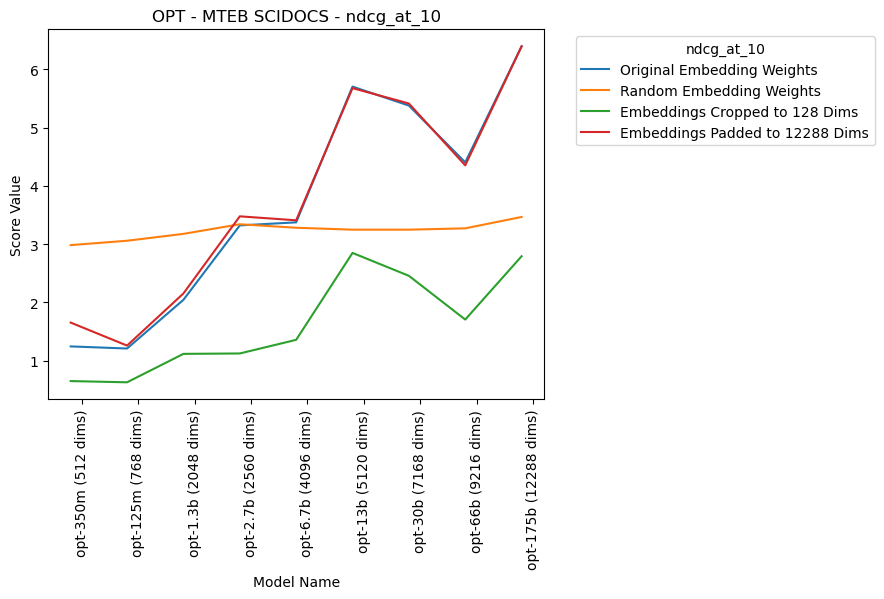

In [177]:
score_types_of_interest = ['ndcg_at_10']
# Plotting
for task_name, score_data in task_scores.items():
    for score_type, model_scores in score_data['scores'].items():
        if score_type not in score_types_of_interest:
            continue # simplifies plot printing
        plt.figure(figsize=(12, 6))
        
        bar_width = 0.2
        index = np.arange(len(model_names))

        fig, ax = plt.subplots()

        for i, analysis_type in enumerate(analysis_types):
            # print(i, analysis_type, model_scores)
            values = [entry[i][analysis_type] for entry in model_scores.values()]
            # print(values)
            ax.plot(values, label=analysis_type_descriptions[analysis_type])

        ax.set_xticks(index + 0.2)
        ax.set_xticklabels([f"{model_name} ({model_sizes[model_name]} dims)" for model_name in model_names])
        ax.legend()
        
        # Improved legend
        ax.legend(title=score_type, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Disable y-axis start from 0
        ax.set_ylim(auto=True)
        
        plt.title(f"{TITLE} - {task_name} - {score_type}")
        plt.xlabel('Model Name')
        plt.ylabel('Score Value')
        plt.xticks(rotation=90)
        
        plt.savefig(os.path.join(plots_dir, f"{TITLE}_{task_name}_{score_type}.png"), bbox_inches='tight')
        plt.show()

## Combined analysis

In [144]:
model_sizes = {
    'pythia-14m':128,
    'pythia-31m':256,
    'pythia-70m':512,
    'pythia-160m':768,
    'pythia-410m':1024,
    'pythia-1b':2048,
    'pythia-1.4b':2048,
    'pythia-2.8b':2560,
    'pythia-6.9B':4096,
    'pythia-12b':5120,
    "opt-350m":512,
    "opt-125m":768,
    "opt-1.3b":2048,
    "opt-2.7b":2560,
    "opt-6.7b":4096,
    "opt-13b":5120,
    "opt-30b":7168,
    "opt-66b":9216,
    "opt-175b":12288,
    "Cerebras-GPT-111M":768,
    "Cerebras-GPT-256M":1088,
    "Cerebras-GPT-590M":1536,
    "Cerebras-GPT-1.3B":2048,
    "Cerebras-GPT-2.7B":2560,
    "Cerebras-GPT-6.7B":4096,
    "Cerebras-GPT-13B":5120,
    "bloom-560m":1024,
    "bloom-1b1":1536,
    "bloom-1b7":2048,
    "bloom-3b":2560,
    "bloom-7b1":4096,
    "bloom":14336,
    "t5-v1_1-small":512,
    "t5-v1_1-base":768,
    "t5-v1_1-large":1024,
    "t5-v1_1-xl":2048,
    "t5-v1_1-xxl":4096,
}

In [145]:
# Dictionary to store scores for each task, score type, and model
df = pd.DataFrame(columns=['model_name', 'analysis_type', 'embedding_size', 'metric_type', 'metric_value'])
task_scores = {}

# Loop through model names
for model_name in model_sizes.keys():
    for analysis_type in analysis_types:
        # Path to metadata file for the current model
        metadata_path = f"{HOME_DIR_WIN}/mteb_analyses/{model_name}_{analysis_type}_mean/mteb_metadata.md"
        
        # Read metadata content
        metadata_content = read_yaml_file(metadata_path)
        
        # Loop through results in metadata
        for result in metadata_content['model-index'][0]['results']:
            task_name = result['dataset']['name']
            if task_name == "MTEB SCIDOCS":
                # print(task_name)
                
                # Initialize dictionaries if not present
                task_scores.setdefault(task_name, {})
                task_scores[task_name].setdefault('scores', {})
                
                # Loop through metrics in the result
                for metric in result['metrics']:
                    if metric['type'] == 'ndcg_at_10':
                        df.loc[-1] = [model_name, analysis_type, model_sizes[model_name], metric['type'], metric['value']]  # adding a row
                        df.index = df.index + 1  # shifting index
                        df = df.sort_index()
                        # print(metric)
                        # score_type = metric['type']
                        # score_value = metric['value']
                        
                        # # Initialize dictionaries if not present
                        # task_scores[task_name]['scores'].setdefault(score_type, {})
                        # task_scores[task_name]['scores'][score_type].setdefault(model_name, [])
                        
                        # # Append the score value to the list
                        # task_scores[task_name]['scores'][score_type][model_name].append({analysis_type: score_value})

df.to_csv(f'{HOME_DIR_WIN}/data/ndcg_at_10.csv', index=False)

[  128   256   512   768  1024  1088  1536  2048  2560  4096  5120  7168
  9216 12288 14336]


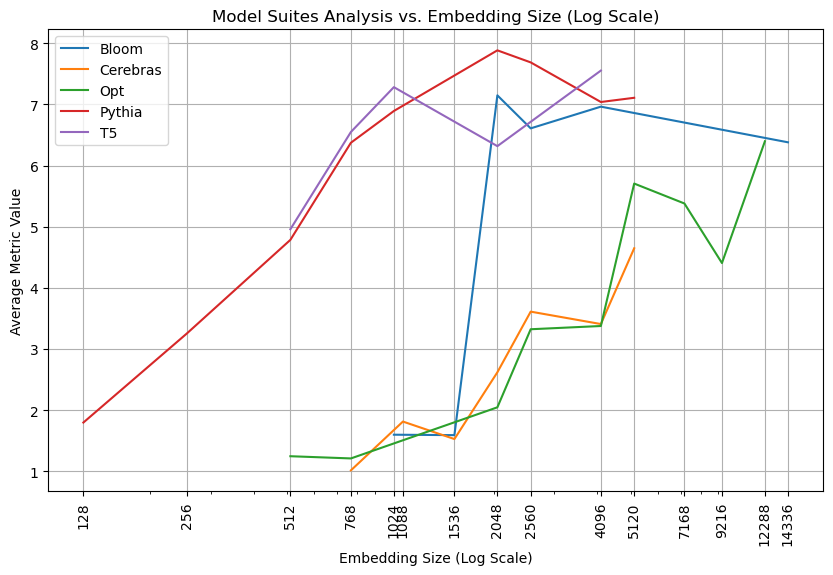

In [146]:
# Step 2: Read CSV
file_path = f'{HOME_DIR_WIN}/data/ndcg_at_10.csv'
data = pd.read_csv(file_path)
ticks = data.embedding_size.unique()
ticks.sort()
print(ticks)


# Step 4: Group Data by Model Suite
data['model_suite'] = data['model_name'].apply(lambda x: x.split('-')[0].capitalize())
full_data = data[data['analysis_type'] == 'full']
data.sort_values(by=['model_suite'])

# Step 5: Plotting
plt.figure(figsize=(10, 6))

for suite_name, group in full_data.groupby('model_suite'):
    avg_values = group.groupby('embedding_size')['metric_value'].mean()
    plt.plot(avg_values.index, avg_values, label=suite_name)

# Step 5.1: Enable Log Scaling on x-axis
plt.xscale('log')
# plt.xticks([128,512,1024,2048,4096,5120,9216,14336])
plt.xticks(ticks)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())

# Step 6: Legend and Labels
plt.legend()
plt.xlabel('Embedding Size (Log Scale)')
plt.ylabel('Average Metric Value')
plt.title('Model Suites Analysis vs. Embedding Size (Log Scale)')
plt.savefig(os.path.join(plots_dir, f"All Model Suites Combined.png"), bbox_inches='tight')
plt.grid(True)
plt.show()

## Random Baseline

In [6]:
model_tok_rand_sizes = [  128,   256,   512,   768,  1024,  1088,  1536,  2048,  2560,  4096,  5120,  7168, 9216, 12288, 14336]

tokenizers = [
                "bigscience/bloom",
                "cerebras/Cerebras-GPT-111M",
                "facebook/opt-350m",
                "google/t5-v1_1-small",
                'EleutherAI/gpt-neox-20b']

tokenizer_nicknames = [
    "Bloom",
    "Cerebras",
    "OPT",
    "T5",
    "GPT-NeoX"
]

tokenizer_embedding_sizes = {
    "bigscience/bloom":250880,
    "cerebras/Cerebras-GPT-111M":50257,
    "facebook/opt-350m":50272,
    "google/t5-v1_1-small":32128,
    'EleutherAI/gpt-neox-20b':50304,
}

TITLE="By Tokenizer"

["random_xn_tok"]

# Dictionary to store scores for each task, score type, and model
df = pd.DataFrame(columns=['tokenizer_name', 'analysis_type', 'embedding_size', 'metric_type', 'metric_value', 'axis_name'])
task_scores = {}

# Loop through model names
for tokenizer_name, tok_nick in zip(tokenizers, tokenizer_nicknames):
    for size in model_tok_rand_sizes:
        # Path to metadata file for the current model
        metadata_path = f"{HOME_DIR_WIN}/mteb_analyses/random_tok_{tok_nick}_7776_{str(size)}_random_xn_tok_mean/mteb_metadata.md"
        
        # Read metadata content
        metadata_content = read_yaml_file(metadata_path)
        
        # Loop through results in metadata
        for result in metadata_content['model-index'][0]['results']:
            task_name = result['dataset']['name']
            if task_name == "MTEB SCIDOCS":
                # print(task_name)
                
                # Initialize dictionaries if not present
                task_scores.setdefault(task_name, {})
                task_scores[task_name].setdefault('scores', {})
                
                # Loop through metrics in the result
                for metric in result['metrics']:
                    if metric['type'] == 'ndcg_at_10':
                        df.loc[-1] = [tok_nick, "random_xn_tok", size, metric['type'], metric['value'], f"{tok_nick}({tokenizer_embedding_sizes[tokenizer_name]} vocab size)"]  # adding a row
                        df.index = df.index + 1  # shifting index
                        df = df.sort_index()
                        # print(metric)
                        # score_type = metric['type']
                        # score_value = metric['value']
                        
                        # # Initialize dictionaries if not present
                        # task_scores[task_name]['scores'].setdefault(score_type, {})
                        # task_scores[task_name]['scores'][score_type].setdefault(model_name, [])
                        
                        # # Append the score value to the list
                        # task_scores[task_name]['scores'][score_type][model_name].append({analysis_type: score_value})
        df.to_csv(f'{HOME_DIR_WIN}/data/random_baseline_ndcg_at_10_7776.csv', index=False)
df.to_csv(f'{HOME_DIR_WIN}/data/random_baseline_ndcg_at_10_7776.csv', index=False)

[  128   256   512   768  1024  1088  1536  2048  2560  4096  5120  7168
  9216 12288 14336]


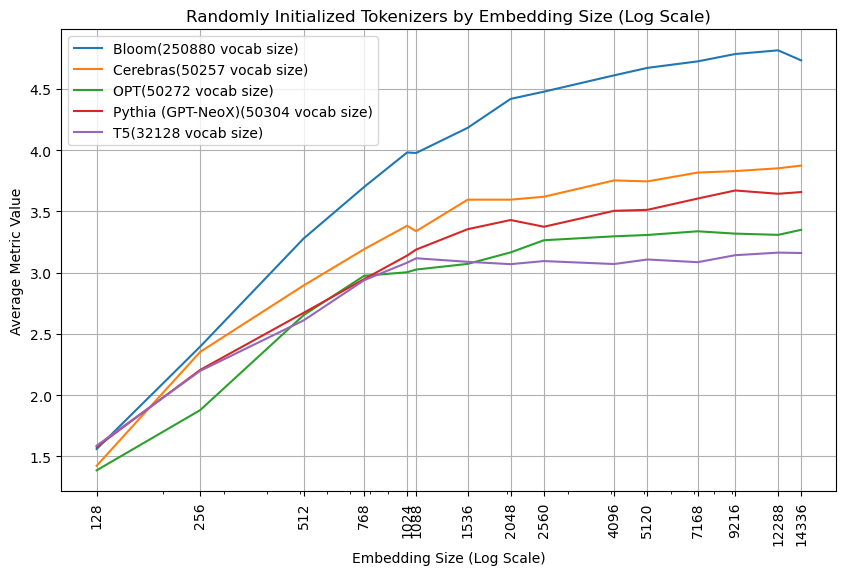

In [7]:
# Step 2: Read CSV
file_path = f'{HOME_DIR_WIN}/data/random_baseline_ndcg_at_10_7776.csv'
data = pd.read_csv(file_path)
ticks = data.embedding_size.unique()
ticks.sort()
print(ticks)

# Step 4: Group Data by Model Suite
data['axis_name'] = data['axis_name'].apply(lambda x: x.replace('GPT-NeoX', "Pythia (GPT-NeoX)")) # This ensures consistent ordering and coloring through the graphs
random_data = data[data['analysis_type'] == 'random_xn_tok']
random_data.sort_values(by=['axis_name'])

# Step 5: Plotting
plt.figure(figsize=(10, 6))

for suite_name, group in random_data.groupby('axis_name'):
    avg_values = group.groupby('embedding_size')['metric_value'].mean()
    plt.plot(avg_values.index, avg_values, label=suite_name)

# Step 5.1: Enable Log Scaling on x-axis
plt.xscale('log')
# plt.xticks([128,512,1024,2048,4096,5120,9216,14336])
plt.xticks(ticks)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())

# Step 6: Legend and Labels
plt.legend()
plt.xlabel('Embedding Size (Log Scale)')
plt.ylabel('Average Metric Value')
plt.title('Randomly Initialized Tokenizers by Embedding Size (Log Scale)')
plt.grid(True)
plt.savefig(os.path.join(plots_dir, f"Randomly_Initilaized_Tokenizers_ndcg_at_10_seed_7776.png"), bbox_inches='tight')
plt.show()